参考：https://blog.csdn.net/dgvv4/article/details/124386024
使用循环神经网络 LSTM 和 GRU 完成对股票数据的预测。GRU 是在 LSTM 基础上的简化，将 LSTM 内部的三个闸门简化成两个，往往 GRU 的计算效果会优于 LSTM

### 导入工具包
这里使用GPU加速计算，加快网络的训练速度

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 获取数据

In [23]:
# pip install pandas_datareader
import pandas_datareader.data as web
import datetime  # datetime是Python处理日期和时间的标准库。
 
# 设置获取股票的时间范围的数据
start = datetime.datetime(2000,1,1)  # 设置开始时间
end = datetime.datetime(2021,9,1)  # 设置结束时间
 
# 在stooq数据源上获取googl在2000-2021年的股票数据
df = web.DataReader('GOOGL', 'stooq', start, end)
# 查看股票信息, 时间, 开盘价, 最高价, 最低价, 收盘价, 交易量
print(df)
 
df.dropna(inplace=True)  # 删除表格中的空值
 
# 根据数据的索引（时间）从小到大排序
df.sort_index(inplace=True)  # 排序完成后替换原来的df
print(df)
 
# 获取标签，预测10天后的收盘价
pre_days = 10
# 添加一个新的列存放标签, 相当于通过2004-08-19的特征来预测2004-08-29的收盘价
df['label'] = df['Close'].shift(-pre_days)
print(df)

                 Open      High        Low      Close       Volume
Date                                                              
2021-09-01  145.00000  146.2540  144.88400  145.21600   21936100.0
2021-08-31  145.14700  145.1710  144.28100  144.69800   22448760.0
2021-08-30  144.40000  145.9700  144.16300  144.59000   24434200.0
2021-08-27  141.65200  144.5120  141.49700  144.00400   28780200.0
2021-08-26  141.75000  142.4180  141.35700  141.44000   20609320.0
...               ...       ...        ...        ...          ...
2004-08-25    2.62400    2.7000    2.59700    2.65000  183956000.0
2004-08-24    2.78100    2.7900    2.58925    2.62175  305252000.0
2004-08-23    2.76875    2.8370    2.72625    2.73500  365488000.0
2004-08-20    2.52525    2.7270    2.51250    2.70775  457144000.0
2004-08-19    2.50000    2.6015    2.39900    2.50850  894076000.0

[4290 rows x 5 columns]
                 Open      High        Low      Close       Volume
Date                                 

### 数据预处理
导入 sklearn 标准化方法，对所有的特征数据进行标准化处理，对标签数据 'label' 列不做处理。标准化后能够避免偏差过大的数据对训练结果的影响。

In [24]:
from sklearn.preprocessing import StandardScaler  # 导入数据标准化方法
 
scaler = StandardScaler()  # 接收数据标准化方法
# 对所有的特征数据进行标准化，最后一列是标签值
sca_x = scaler.fit_transform(df.iloc[:,:-1])
# 查看标准化后的特征数据
print(sca_x)

[[-1.08801025 -1.08523108 -1.0896121  -1.08666784  4.89712792]
 [-1.08705235 -1.08051435 -1.08526914 -1.07911788  2.09105043]
 [-1.0778148  -1.07638016 -1.0770902  -1.07808533  1.50241458]
 ...
 [ 4.29518602  4.30306354  4.33484979  4.29707174 -0.68791113]
 [ 4.32352462  4.2730343   4.33936494  4.30116406 -0.70066208]
 [ 4.31794795  4.31373726  4.36243815  4.32079207 -0.7039545 ]]


### 时间序列滑窗
这里使用一个很方便的队列deque，指定这个队列的最大长度maxlen=20，就代表一个时间序列的长度为20，如果队列deq的长度超过20就将第1个特征删除，将第21个特征追加到第20个特征后面，就能一直保持队列的长度是20。那么每一个时间序列的shape=[20,5]，代表20行数据5列特征。

完成对所有数据的时间序列分组之后，由于特征数据sca_x最后10行是没有对应的标签值的。因此需要把最后10组时间序列删除。每一个序列对应一个标签，标签和序列的长度是相同的。

In [25]:
import numpy as np
from collections import deque  # 相当于一个列表，可以在两头增删元素
 
men_his_days = 20  # 用20天的特征数据来预测
# 创建一个队列, 长度等于记忆的天数，时间序列滑窗大小=20
deq = deque(maxlen=men_his_days)
 
# 创建一个特征列表，保存每个时间序列的特征
x = []
# 遍历每一行特征数据
for i in sca_x:
    # 将每行特征保存进队列
    deq.append(list(i))  # array类型转为list类型
    # 如果队列的长度等于记忆的天数（时间滑窗的的长度）就证明特征组成了一个时间序列
    # 如果队列长度大于记忆天数，队列会自动将头端的那个特征删除，将新输入追加到队列尾部
    if len(deq) == men_his_days:
        # 将这一组序列保存下来
        x.append(list(deq))  # array类型转为list类型
 
# 由于原特征中最后10条数据没有标签值, 在x特征数据中将最后10个序列删除
x = x[:-pre_days]
# 查看有多少个序列
print(len(x))  # 4260
 
# 数据表格df中最后一列代表标签值, 把所有标签取出来
# 例如使用[0,1,2,3,4]天的特征预测第20天的收盘价, 使用[1,2,3,4,5]天的特征预测第21天的收盘价
# 而表格中索引4对应的标签就是该序列的标签
y = df['label'].values[men_his_days-1: -pre_days]
print(len(y))  # 序列x和标签y的长度应该一样
 
# 将特征和标签变成numpy类型
x, y = np.array(x), np.array(y)

4260
4260


### 划分数据集

我们已经获得了处理后的时间序列和对应的标签，接下来就按比例划分训练集、验证集、测试集即可。对于训练集需要使用 .shuffle() 随机打乱数据行排列顺序，避免偶然性。设置迭代器 iter()，结合 next() 函数从训练集中取出一个batch的数据

In [26]:
total_num = len(x)  # 一共多少组序列和标签
train_num = int(total_num*0.8)  # 80%的数据用于训练
val_num = int(total_num*0.9)  # 80-90%的数据用于验证
# 剩余的数据用于测试
 
x_train, y_train = x[:train_num], y[:train_num]  # 训练集
x_val, y_val = x[train_num:val_num], y[train_num:val_num]  # 验证集
x_test, y_test = x[val_num:], y[val_num:]  # 测试集
 
# 转为tensor类型
batch_size = 128  # 每个step训练多少组序列数据
# 训练集
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(batch_size).shuffle(10000)  # 随机打乱
# 验证集
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size)
# 测试集
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(batch_size)
 
# 查看数据集信息
sample = next(iter(train_ds))  # 取出一个batch的数据
print('x_train.shape:', sample[0].shape)  # (128, 20, 5)
print('y_train.shape:', sample[1].shape)  # (128,)

x_train.shape: (128, 20, 5)
y_train.shape: (128,)


### 模型构建
这里以 GRU 网络为例，LSTM 只需要将下面代码中的 layers.GRU() 换成 layers.LSTM() 即可。

要注意参数 return_sequences，代表返回输出序列中的最后一个值，还是所有值。默认False。一般是下一层还是 LSTM 的时候才用 return_sequences=True

In [27]:
input_shape = sample[0].shape[-2:]  # [20,5] 输入维度不需要写batch维度
 
# 构造输入层
inputs = keras.Input(shape=input_shape)  # [None,20,5]
 
# 第一个GRU层, 如果下一层还是LSTM层就需要return_sequences=True, 否则就是False
x = layers.GRU(8, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01))(inputs)
x = layers.Dropout(0.2)(x)  # 随机杀死神经元防止过拟合
 
# 第二个GRU层
x = layers.GRU(16, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)  
 
# 第三个GRU层
x = layers.GRU(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)  
 
# 全连接层, 随机权重初始化, l2正则化
x = layers.Dense(16, activation='relu', kernel_initializer='random_normal', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)  
 
# 输出层, 输入序列的10天后的股票，是时间点。保证输出层神经元个数和y_train.shape[-1]相同
outputs = layers.Dense(1)(x)
 
# 构造网络
model = keras.Model(inputs, outputs)
 
# 查看网络结构
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 gru_6 (GRU)                 (None, 20, 8)             360       
                                                                 
 dropout_8 (Dropout)         (None, 20, 8)             0         
                                                                 
 gru_7 (GRU)                 (None, 20, 16)            1248      
                                                                 
 dropout_9 (Dropout)         (None, 20, 16)            0         
                                                                 
 gru_8 (GRU)                 (None, 32)                4800      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0   

### 网络训练
首先进行模型编译，使用adam优化器设置学习率0.01，使用平均绝对误差作为网络训练时的损失函数，网络迭代20次。回归问题不能设置metrics监控指标为准确率，这一般用于分类问题。

In [28]:
# 网络编译
model.compile(optimizer = keras.optimizers.Adam(0.001),  # adam优化器学习率0.001
              loss = tf.keras.losses.MeanAbsoluteError(),  # 标签和预测之间绝对差异的平均值
              metrics = tf.keras.losses.MeanSquaredLogarithmicError())  # 计算标签和预测之间的对数误差均方值。
 
epochs = 10  # 网络迭代次数
 
# 网络训练
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
 
# 测试集评价
model.evaluate(test_ds)  # loss: 0.1212

Epoch 1/10
27/27 [==============================] - 4s 42ms/step - loss: 20.8164 - mean_squared_logarithmic_error: 8.4326 - val_loss: 58.1521 - val_mean_squared_logarithmic_error: 14.9408
Epoch 2/10
27/27 [==============================] - 0s 16ms/step - loss: 19.8171 - mean_squared_logarithmic_error: 5.8917 - val_loss: 52.7119 - val_mean_squared_logarithmic_error: 4.7723
Epoch 3/10
27/27 [==============================] - 0s 16ms/step - loss: 11.7733 - mean_squared_logarithmic_error: 0.6909 - val_loss: 9.7666 - val_mean_squared_logarithmic_error: 0.0354
Epoch 4/10
27/27 [==============================] - 0s 16ms/step - loss: 5.7712 - mean_squared_logarithmic_error: 0.1878 - val_loss: 6.8217 - val_mean_squared_logarithmic_error: 0.0177
Epoch 5/10
27/27 [==============================] - 0s 16ms/step - loss: 4.9012 - mean_squared_logarithmic_error: 0.1113 - val_loss: 4.1951 - val_mean_squared_logarithmic_error: 0.0070
Epoch 6/10
27/27 [==============================] - 0s 16ms/step - lo

[12.167525291442871, 0.024804681539535522]

### 查看训练信息
history变量中保存了训练过程的所有信息，我们绘制训练集损失和验证集损失曲线。

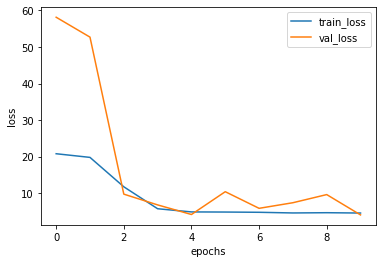

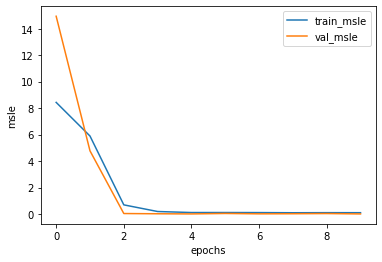

In [29]:
#（10）查看训练信息
history_dict = history.history  # 获取训练的数据字典
train_loss = history_dict['loss']  # 训练集损失
val_loss = history_dict['val_loss']  # 验证集损失
train_msle = history_dict['mean_squared_logarithmic_error']  # 训练集的百分比误差
val_msle = history_dict['val_mean_squared_logarithmic_error']  # 验证集的百分比误差
 
#（11）绘制训练损失和验证损失
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')  # 训练集损失
plt.plot(range(epochs), val_loss, label='val_loss')  # 验证集损失
plt.legend()  # 显示标签
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
 
#（12）绘制训练百分比误差和验证百分比误差
plt.figure()
plt.plot(range(epochs), train_msle, label='train_msle')  # 训练集损失
plt.plot(range(epochs), val_msle, label='val_msle')  # 验证集损失
plt.legend()  # 显示标签
plt.xlabel('epochs')
plt.ylabel('msle')
plt.show()

### 预测
使用 evaluate() 函数对整个测试集计算损失和监控指标，获取每个真实值的时间刻度

14/14 [==============================] - 0s 3ms/step


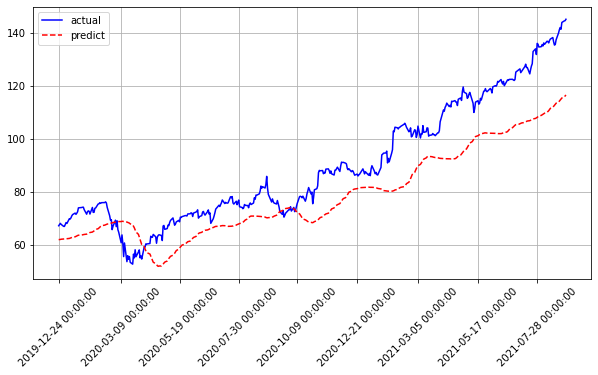

In [30]:
#（13）测试集评价, 计算损失和监控指标
model.evaluate(test_ds)
 
# 预测
y_pred = model.predict(x_test)
 
# 获取标签值对应的时间
df_time = df.index[-len(y_test):]
 
# 绘制对比曲线
fig = plt.figure(figsize=(10,5))  # 画板大小
axes = fig.add_subplot(111)  # 画板上添加一张图
# 真实值, date_test是对应的时间
axes.plot(df_time, y_test, 'b-', label='actual')
# 预测值，红色散点
axes.plot(df_time, y_pred, 'r--', label='predict')
# 设置横坐标刻度
axes.set_xticks(df_time[::50])
axes.set_xticklabels(df_time[::50], rotation=45)
 
plt.legend()  # 注释
plt.grid()  # 网格
plt.show()